# Retail Sales: Clothing and Clothing Accessory Stores

###
 Data Source and Credits

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 7, 2022.



<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
Copyright Pierian Data
For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com


In [218]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [219]:
df= pd.read_csv('RSCCASN.csv',parse_dates=True, index_col='DATE')

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 1992-01-01 to 2022-09-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  369 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB


In [221]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [222]:
df.columns= ['Sales']

<AxesSubplot: xlabel='DATE'>

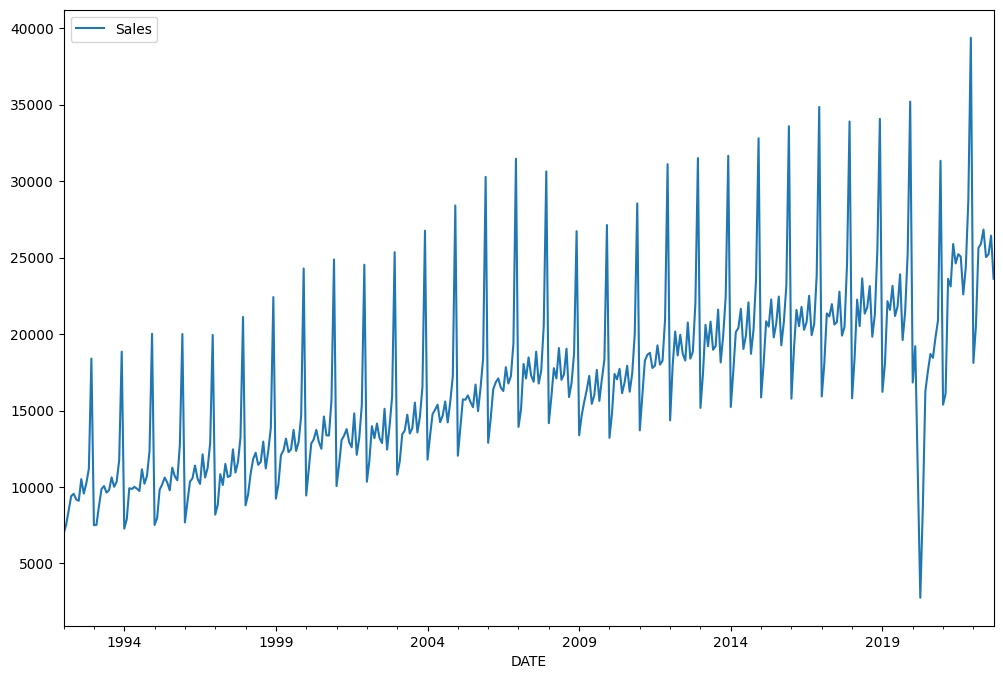

In [223]:
df.plot(figsize=(12,8))

In [224]:
len(df)

369

In [225]:
#Our test data will be 14 months
len(df)-14

355

In [226]:
test_size= 14
test_index=len(df)-test_size

In [227]:
train=df.iloc[:test_index] #My train set will be all the way until my test index
test=df.iloc[test_index:] #My test set will start in my test index and all the way to the end


In [228]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2021-03-01,23616
2021-04-01,23115
2021-05-01,25886


In [229]:
test

,Sales
DATE,
2021-08-01,25063
2021-09-01,22592
2021-10-01,24366
2021-11-01,28725
2021-12-01,39375
2022-01-01,18113
2022-02-01,20509
2022-03-01,25622
2022-04-01,25904


Scaling the Data

In [230]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

In [231]:
scaler.fit(train)

MinMaxScaler()

In [232]:
scaled_train=scaler.transform(train)

In [233]:
scaled_test= scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for training/validation.

#### Arguments
 **data:** Indexable generator (such as list or Numpy array) containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected to be the time dimension.
       
 **targets:** Targets corresponding to timesteps in `data`. It should have same length as `data`.

 **length:** Length of the output sequences (in number of timesteps).

 **sampling_rate:** Period between successive individual timesteps within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]` are used for create a sample sequence.

 **stride:** Period between successive output sequences. For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.

 **start_index:** Data points earlier than `start_index` will not be used in the output sequences. This is useful to reserve part of the
        data for test or validation.

 **end_index:** Data points later than `end_index` will not be used in the output sequences. This is useful to reserve part of the
        data for test or validation.

 **shuffle:** Whether to shuffle output samples,or instead draw them in chronological order.

 **reverse:** Boolean: if `true`, timesteps in each output sample will be in reverse chronological order.
 
 **batch_size:** Number of timeseries samples in each batch (except maybe the last one).


In [234]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [235]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

#Length: is the length of the batch (12 months)
#Batch_size:The number of samples to return on each iteration.
#When it comes to time series sequencies, it works best with a batch_size of 1.

In [236]:
# How the first batch look like:
X,y=generator[0]

In [237]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.12878064 0.14684754 0.17616772 0.20471713 0.20955758 0.19796516
 0.19552952 0.23900108 0.21002004 0.23101588 0.2597811  0.48201017]
Predict this y: 
 [[0.14616926]]


In [238]:
len(X[0])

12

Given the length of 12 months go and predict the 13th month (that is 1 batch)

## Creating the Model
Now, we need to create our model and then we will add in the early stopping by creating a validation generator and then we can evaluate our model.

In [239]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [240]:
#The number of features in our df is actually one (Sales)
n_features= 1

In [241]:
model = Sequential()
model.add(LSTM(100,activation='relu',input_shape=(length,n_features)))
#Final dense layer to have one predicted value
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')  #'mse' for continuos data


In [242]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [243]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [244]:
validation_generator= TimeseriesGenerator(scaled_test,scaled_test,length=length, batch_size=1)

NOTES: 
- The scaled_test dataset size MUST be greater than your length chosen for your batches.
- The early_stop and the validation_generator are used for LSTM, not with SimpleRNN.

In [245]:
# fit model
model.fit_generator(generator,epochs=60,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/60


/tmp/ipykernel_92123/2032660093.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=60,


343/343 [==============================] - 3s 5ms/step - loss: 0.0205 - val_loss: 0.0021
Epoch 2/60
343/343 [==============================] - 2s 5ms/step - loss: 0.0158 - val_loss: 0.0013
Epoch 3/60
343/343 [==============================] - 2s 5ms/step - loss: 0.0112 - val_loss: 0.0050
Epoch 4/60
343/343 [==============================] - 2s 5ms/step - loss: 0.0080 - val_loss: 0.0059


In [246]:
losses= pd.DataFrame(model.history.history)

<AxesSubplot: >

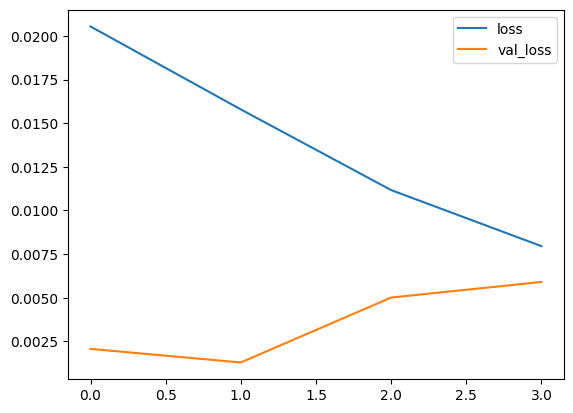

In [247]:
losses.plot()

It looks like we got quite a bit of noise. So it's probably better to have a little more patience but not too much patience because  you'll probably start getting too much noise. It is a bit of a balance there.

## Evaluate on Test Data

In [248]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [249]:
true_predictions = scaler.inverse_transform(test_predictions)

In [250]:
test['Predictions'] = true_predictions

/tmp/ipykernel_92123/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [251]:
test

,Sales,Predictions
DATE,,
2021-08-01,25063,21802.533871
2021-09-01,22592,21700.990448
2021-10-01,24366,22593.070028
2021-11-01,28725,24665.525200
2021-12-01,39375,32958.512599
2022-01-01,18113,20778.678289
2022-02-01,20509,21574.360828
2022-03-01,25622,26228.024524
2022-04-01,25904,26063.885470


<AxesSubplot: xlabel='DATE'>

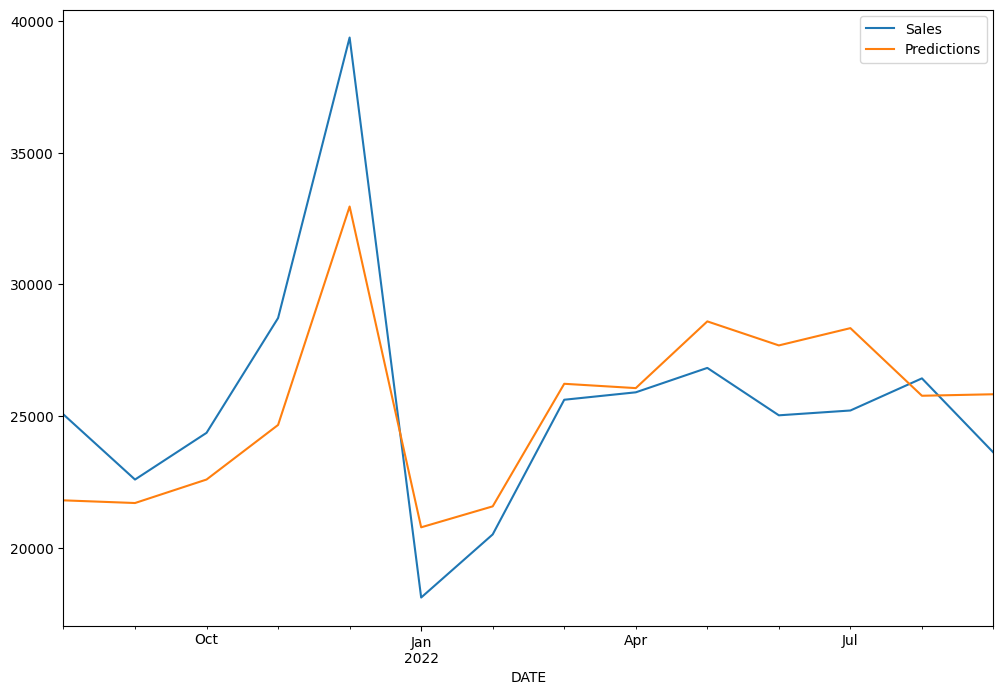

In [252]:
test.plot(figsize=(12,8))

The predictions look quite good. Granted, they're not perfect, but given the fact that at the end we're essentially forecasting off forecasts and also that we saw that the market had an out-of-normal behavior between December 2019 and almost September 2021, the general seasonality trends tend to line up.

- So we can try experimenting with the default activation function of LSTM instead of using the rectify linnear unit, and see if that improves your results.

- Another option is removing or adding more neurons to the LSM layers,etc

- But let's go ahead and try to forecast into the unknown future.


# Retrain and Forecasting

In [254]:
full_scaler= MinMaxScaler()

#Here I can fit_transformed to all my data, since the quote unquote forecast section doesn't really exist for me.

scaled_full_data= full_scaler.fit_transform(df)

In [255]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

A really common question is **how many epochs should I be choosing and why can't I just do an early stop call back again when I'm forecasting into the unknown future after retraining on my entire data set?**


The way the early stopping works is it evaluates your validation losss, recall that validation_generator is validating your model and evaluating your model on data that the model does not get to train on.

However, by definition for this forecast, we're training on the full data set.
So there is no chunk of data that we're setting aside that is fair game for evaluation because the model gets to see all the data at once.

It's the fact that we're forecasting to the unknown future.
So we should be using all the data right up to the present day, which then doesn't really allow us to save anything for a test set for some sort of early stopping mechanism, which is why it's so important to essentially do that step during the testing phase.

And because of that, you should be choosing your number of epochs essentially based off the losses chart before where we found a minimum in the val_loss curve.

In [256]:
model=Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

model.fit_generator(generator, epochs=3)


Epoch 1/3


/tmp/ipykernel_92123/500768024.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=3)


357/357 [==============================] - 3s 5ms/step - loss: 0.0201
Epoch 2/3
357/357 [==============================] - 2s 6ms/step - loss: 0.0133
Epoch 3/3
357/357 [==============================] - 2s 5ms/step - loss: 0.0110


In [257]:
forecast = []
#Replce periods with whatever forecast length you want
periods= 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 18ms/step


In [258]:
forecast = scaler.inverse_transform(forecast)

In [259]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2022-05-01,26831
2022-06-01,25031
2022-07-01,25214


In [260]:
forecast

array([[19578.72440255],
       [19404.78943533],
       [19781.19259989],
       [22200.46407139],
       [24716.38970917],
       [18325.80743572],
       [19108.09720045],
       [21037.14384443],
       [20821.07891238],
       [21783.75788844],
       [21033.17869401],
       [21003.01184511]])

In [261]:
forecast_index = pd.date_range(start='2022-10-01',periods=periods, freq='MS')
#FREQUENCY= mounthly (MS)

In [262]:
forecast_index

DatetimeIndex(['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [263]:
forecast_df=pd.DataFrame(data=forecast, index=forecast_index,columns=['Forecast'])

<AxesSubplot: >

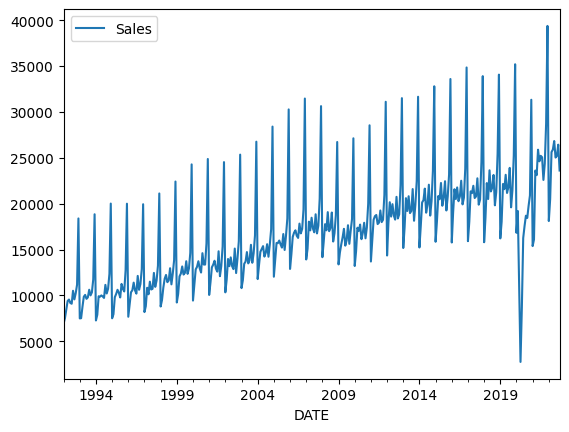

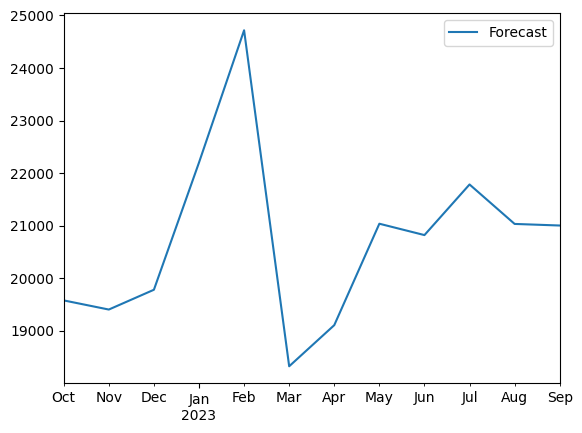

In [264]:
df.plot()
forecast_df.plot()

<AxesSubplot: xlabel='DATE'>

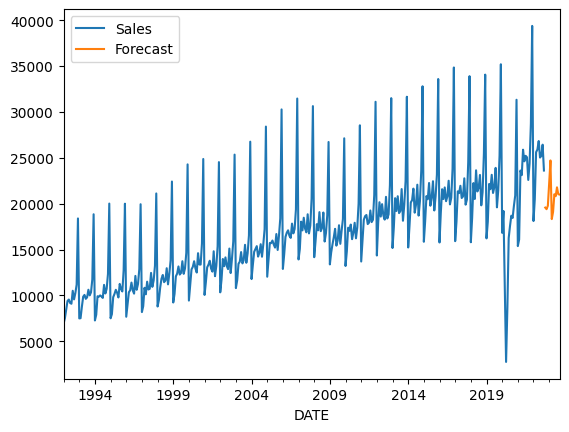

In [265]:
ax=df.plot()
forecast_df.plot(ax=ax)

(588.0, 644.0)

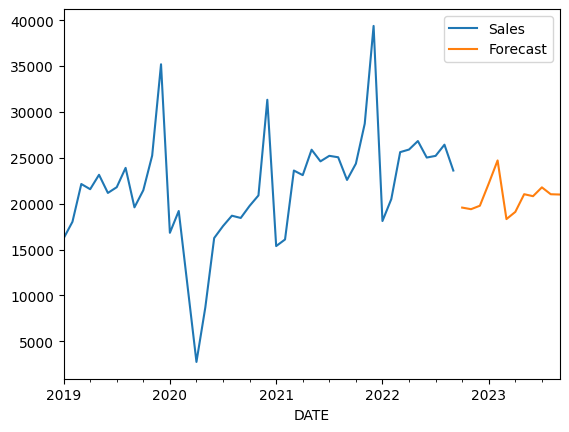

In [266]:
ax=df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2019-01-01','2023-09-01')

This forecast makes sense given the previous patterns-

Then the question is, well, how good is this forecast? Unfortunately, there's no true way of knowing that until the 2023 months.